### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from models.aef_linear import LinearAEF
from models.autoencoder import ConvolutionalEncoderSmall, IndependentVarianceDecoderSmall
from models.aef_internal import InternalAEF
from bijectors.masked_autoregressive_transform import get_masked_autoregressive_transform

from util import dequantize

from nflows.transforms import InverseTransform, AffineTransform
from bijectors.actnorm import ActNorm
from bijectors.sigmoid import Sigmoid

from visualize import plot_samples

### Data

In [2]:
transform = transforms.ToTensor()

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Network
To define our model we require an encoder and decoder, and two normalizing flows. We choose a simple convolutional encoder which outputs a mean and standard deviation, a simple convolutional decoder with a learnable variance, and two masked autoregressive flows.
For AEF-linear we do not require a mask, but the downside is that the likelihood will be of an extended ambient space. An importance sampling algorithm to approximate the likelihood of just the datapoint can be found in the code. For the internal version of AEF, for which we do require a mask, see the end of the notebook.

In [3]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

hidden_channels = 64
img_shape = [1, 28, 28]
alpha = 1e-6
latent_dims = 2

encoder = ConvolutionalEncoderSmall(hidden_channels, img_shape, latent_dims)
decoder = IndependentVarianceDecoderSmall(hidden_channels, img_shape, latent_dims)

flow_features = 256
num_layers = 4
core_encoder = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

prior_flow = get_masked_autoregressive_transform(features=latent_dims, hidden_features=flow_features, num_layers=num_layers,
                                                   num_blocks_per_layer=2, act_norm_between_layers=True)

preprocessing_layers = [InverseTransform(AffineTransform(alpha, 1 - 2 * alpha)), Sigmoid(),
                           ActNorm(img_shape[0])]

aef = LinearAEF(encoder, decoder, core_encoder, prior_flow, preprocessing_layers=preprocessing_layers) # AEF linear requires no mask
aef = aef.to(device)

### Training

Training for 5000 iterations...


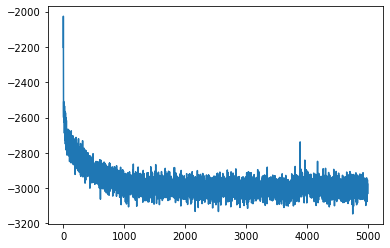

In [4]:
optimizer = torch.optim.Adam(params=aef.parameters(), lr=1e-3)

n_iterations = 5000
stop = False

losses = []

stop = False
n_iters_done = 0
print(f'Training for {n_iterations} iterations...')
while not stop:
    for image_batch, _ in trainloader:
        image_batch = dequantize(image_batch)
        image_batch = image_batch.to(device)

        loss = torch.mean(aef.loss_function(image_batch))
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        n_iters_done += 1
        if n_iters_done >= n_iterations:
            stop = True
            break
plt.plot(range(n_iterations), losses)

In [5]:
aef.eval()
test_losses = np.zeros((len(testloader)))

with torch.no_grad():
    for batch_idx, (test_batch, _) in enumerate(testloader):
        test_batch = dequantize(test_batch)
        test_batch = test_batch.to(device)
        loss = torch.mean(aef.loss_function(test_batch))
        test_losses[batch_idx] = loss.item()

print(f'Test log-likelihood: {test_losses.mean()}')

Test log-likelihood: -3010.1556314584163


### Visualizations

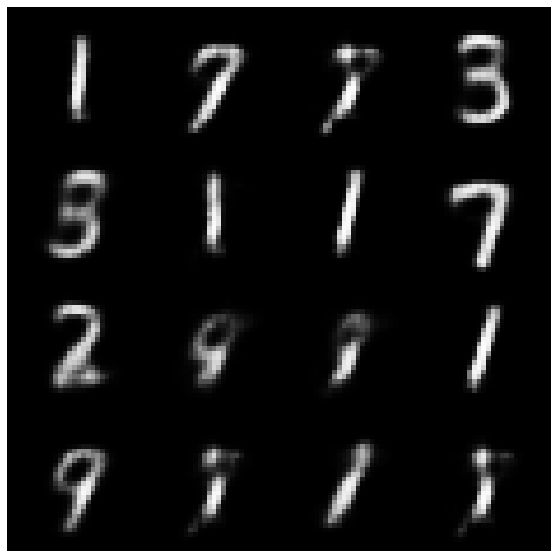

In [6]:
fig = plot_samples(aef, img_shape, n_rows=4, n_cols=4)
plt.show()

### AEF Internal
We need to create a mask, that will define which pixels are used as 'core' pixels. For simplicity, we choose the first two pixels of the top row of the image. However, there are no restrictions to this mask, as long as the number of masked values is equal to the core size.

In [7]:
mask = torch.zeros(img_shape)
mask[0, 0, :2] = 1

aef = InternalAEF(encoder, decoder, core_encoder, prior_flow, mask, preprocessing_layers)